Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Probability of surges

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import xgboost
import sklearn.metrics as metrics
from sklearn.utils import resample


import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Polygon

import rioxarray as rx

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced_clean/df_modelling.csv', index_col=['rgiid', 'x', 'y'])
df_main

/home/colili/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Surge   BgnDate  EndDate   CenLon  \
rgiid          x             y                                                 
RGI60-07.00004 524634.335707 8.539882e+06      0  20080901 -9999999  15.9932   
               524633.930457 8.539906e+06      0  20080901 -9999999  15.9932   
               524657.521964 8.539931e+06      0  20080901 -9999999  15.9932   
               524681.113471 8.539955e+06      0  20080901 -9999999  15.9932   
               524704.704977 8.539980e+06      0  20080901 -9999999  15.9932   
...                                          ...       ...      ...      ...   
RGI60-07.01567 534310.362510 8.675249e+06      3  20040713 -9999999  16.5502   
               534309.250485 8.675291e+06      3  20040713 -9999999  16.5502   
               534308.138459 8.675333e+06      3  20040713 -9999999  16.5502   
               534307.026431 8.675375e+06      3  20040713 -9999999  16.5502   
               534347.900282 8.675418e+06      3  20040713 -9999999  16.5502   

                                            CenLat   Area  Zmin  Zmax  Zmed  \
rgiid          x             y                                                
RGI60-07.00004 524634.335707 8.539882e+06  76.9423  1.044   665   933   799   
               524633.930457 8.539906e+06  76.9423  1.044   665   933   799   
               524657.521964 8.539931e+06  76.9423  1.044   665   933   799   
               524681.113471 8.539955e+06  76.9423  1.044   665   933   799   
               524704.704977 8.539980e+06  76.9423  1.044   665   933   799   
...                                            ...    ...   ...   ...   ...   
RGI60-07.01567 534310.362510 8.675249e+06  78.1217  5.350   304   970   656   
               534309.250485 8.675291e+06  78.1217  5.350   304   970   656   
               534308.138459 8.675333e+06  78.1217  5.350   304   970   656   
               534307.026431 8.675375e+06  78.1217  5.350   304   970   656   
               534347.900282 8.675418e+06  78.1217  5.350   304   970   656   

                                           Slope  ...    Runoff         ELA  \
rgiid          x             y                    ...                         
RGI60-07.00004 524634.335707 8.539882e+06   13.8  ...  1.110227  431.471268   
               524633.930457 8.539906e+06   13.8  ...  1.105706  431.784498   
               524657.521964 8.539931e+06   13.8  ...  1.100061  432.103017   
               524681.113471 8.539955e+06   13.8  ...  1.094416  432.421537   
               524704.704977 8.539980e+06   13.8  ...  1.088771  432.740057   
...                                          ...  ...       ...         ...   
RGI60-07.01567 534310.362510 8.675249e+06   11.7  ...  2.127417  627.625366   
               534309.250485 8.675291e+06   11.7  ...  2.076787  627.625366   
               534308.138459 8.675333e+06   11.7  ...  2.005969  627.625366   
               534307.026431 8.675375e+06   11.7  ...  1.935151  627.625366   
               534347.900282 8.675418e+06   11.7  ...  1.917944  627.625366   

                                               beta       cmb  Bed_slope  \
rgiid          x             y                                             
RGI60-07.00004 524634.335707 8.539882e+06  0.005068  1.388794        NaN   
               524633.930457 8.539906e+06  0.005069  1.394411        NaN   
               524657.521964 8.539931e+06  0.005069  1.392706        NaN   
               524681.113471 8.539955e+06  0.005068  1.391001  12.654898   
               524704.704977 8.539980e+06  0.005068  1.389296  12.654898   
...                                             ...       ...        ...   
RGI60-07.01567 534310.362510 8.675249e+06  0.004614 -1.423469   4.401905   
               534309.250485 8.675291e+06  0.004618 -1.395654   4.401905   
               534308.138459 8.675333e+06  0.004620 -1.382369  -0.158243   
               534307.026431 8.675375e+06  0.004621 -1.369084  -0.158243   
               534347.900282 8.675

In [4]:
df = df_main.drop(df_main[df_main['Surge']==9].index)
df = df.drop(df_main[df_main['Surge']==1].index)
# df = df_main.drop(df_main[df_main['Surge']==2].index)
df = df.drop(columns = ['BgnDate', 'EndDate', 'CenLon', 'CenLat', 'Area',
       'Zmin', 'Zmax', 'Zmed', 'Aspect', 'Lmax', 'Status', 'Connect',
       'Form', 'Linkages', 'Name', 'check_geom', 'geometry', 'ELA', 'beta',
        'Slope', 'TermType', 'cmb'])
df.dropna(how='any', inplace=True)

In [5]:
df.groupby('Surge').count()

,bed,thickness,surface_elevation,width_centerline,Runoff,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc
Surge,,,,,,,,,,,
0,66693,66693,66693,66693,66693,66693,66693,66693,66693,66693,66693
2,4195,4195,4195,4195,4195,4195,4195,4195,4195,4195,4195
3,10742,10742,10742,10742,10742,10742,10742,10742,10742,10742,10742


In [6]:
df['Surge'] = df['Surge'].replace({3: 1, 2:1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    66693
1    14937
Name: label, dtype: int64

In [7]:
df[df['label']==1].shape[0]

14937

In [8]:
df.shape

(81630, 12)

### Resampled

In [9]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [10]:
df_downsampled.shape

(29874, 12)

In [11]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [12]:
# Features for feature importances
features = list(train.columns)
features

['bed',
 'thickness',
 'surface_elevation',
 'width_centerline',
 'Runoff',
 'Bed_slope',
 'Surface_slope',
 'WHsin',
 'WH',
 'dummy',
 'SMB_calc']

# Gradient boosting

In [13]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [14]:
df_main = df_main.drop(columns = ['BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'Zmin', 'Zmax', 'Zmed', 'Aspect', 'Lmax', 'Status', 'Connect',
       'Form', 'Linkages', 'check_geom', 'geometry',
        'Slope', 'TermType'])

In [15]:
df_main.columns

Index(['Surge', 'Area', 'Name', 'bed', 'thickness', 'surface_elevation',
       'width_centerline', 'Runoff', 'ELA', 'beta', 'cmb', 'Bed_slope',
       'Surface_slope', 'WHsin', 'WH', 'dummy', 'SMB_calc'],
      dtype='object')

In [16]:
df_main.dropna().shape

(72006, 17)

In [17]:
df_main.dropna(inplace=True)

In [18]:
test_full_labels = df_main['Surge']
# test_full = df_main.dropna(inplace=True)
test_full = df_main.drop(columns=['Surge', 'Area', 'Name', 'ELA', 'beta', 'cmb'])

test_full

bed  thickness  \
rgiid          x             y                                    
RGI60-07.00006 537340.603079 8.536963e+06  565.43870  23.561293   
               537277.114391 8.537023e+06  547.37540  24.624578   
               537213.625703 8.537084e+06  514.92160  27.078419   
               537150.137016 8.537144e+06  468.15363  33.846375   
               537088.154264 8.537143e+06  468.15363  33.846375   
...                                              ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06  237.64468  50.380424   
               534310.362510 8.675249e+06  233.07228  46.717087   
               534309.250485 8.675291e+06  233.07228  46.717087   
               534308.138459 8.675333e+06  233.18828  47.159560   
               534307.026431 8.675375e+06  233.18828  47.159560   

                                           surface_elevation  \
rgiid          x             y                                 
RGI60-07.00006 537340.603079 8.536963e+06          589.00000   
               537277.114391 8.537023e+06          572.00000   
               537213.625703 8.537084e+06          542.00000   
               537150.137016 8.537144e+06          502.00000   
               537088.154264 8.537143e+06          502.00000   
...                                                      ...   
RGI60-07.01567 534269.488654 8.675206e+06          288.02512   
               534310.362510 8.675249e+06          279.78937   
               534309.250485 8.675291e+06          279.78937   
               534308.138459 8.675333e+06          280.34784   
               534307.026431 8.675375e+06          280.34784   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00006 537340.603079 8.536963e+06       1144.919151  1.520206   
               537277.114391 8.537023e+06       1105.995748  1.453610   
               537213.625703 8.537084e+06       1069.477866  1.434204   
               537150.137016 8.537144e+06       1244.957956  1.451109   
               537088.154264 8.537143e+06       1162.234761  1.468375   
...                                                     ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06        278.553621  2.123592   
               534310.362510 8.675249e+06        256.755923  2.127417   
               534309.250485 8.675291e+06        238.477978  2.076787   
               534308.138459 8.675333e+06        226.342325  2.005969   
               534307.026431 8.675375e+06        215.631320  1.935151   

                                           Bed_slope  Surface_slope  \
rgiid          x             y                                        
RGI60-07.00006 537340.603079 8.536963e+06  16.548017      17.115082   
               537277.114391 8.537023e+06  11.640512      10.972421   
               537213.625703 8.537084e+06  20.310906      18.888005   
               537150.137016 8.537144e+06  28.074446      24.522008   
               537088.154264 8.537143e+06  28.074446      24.522008   
...                                              ...            ...   
RGI60-07.01567 534269.488654 8.675206e+06 -13.251281     -10.615210   
               534310.362510 8.675249e+06   4.401905       7.893963   
               534309.250485 8.675291e+06   4.401905       7.893963   
               534308.138459 8.675333e+06  -0.158243      -0.761801   
               534307.026431 8.675375e+06  -0.158243      -0.761801   

                                                  WHsin        WH     dummy  \
rgiid          x             y                                                
RGI60-07.00006 537340.603079 8.536963e+06 -20088.290815  0.020579  0.506675   
               537277.114391 8.537023e+06 -21764.237917  0.022265  0.523348   
               537213.625703 8.537084e+06  28786.494698  0.025319  0.970243   
               537150.137016 8.537144e+06   8366.744828  0.027187  0.485862

In [19]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test[test.columns], label=test_labels)

In [20]:
# params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.5}
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}

xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)
# xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
index = test.index
index

MultiIndex([('RGI60-07.00899', 635253.6555848881, 8714551.968875093),
            ('RGI60-07.01469',  568036.658375825,  8627884.14172063),
            ('RGI60-07.01468',  577167.628354509, 8632792.912002524),
            ('RGI60-07.00314', 579658.0786734116, 8633609.445599038),
            ('RGI60-07.00231', 505755.5011699316, 8597822.645700777),
            ('RGI60-07.00519', 498341.7233301124, 8755927.786959311),
            ('RGI60-07.00364', 573469.2334729374, 8659181.955456609),
            ('RGI60-07.00063', 647034.2398838478, 8672927.844263852),
            ('RGI60-07.01561', 598123.6209855168, 8784127.519098738),
            ('RGI60-07.00305', 455294.2182396368, 8712017.750487667),
            ...
            ('RGI60-07.00360', 566980.1566390167, 8652838.758323738),
            ('RGI60-07.00884',  577002.641227802, 8821286.723816013),
            ('RGI60-07.01100',  481786.781896431, 8645104.445854506),
            ('RGI60-07.01164', 490132.6433688288,  8827680.32955316),
    

In [22]:
test_full.index

MultiIndex([('RGI60-07.00006', 537340.6030786886, 8536962.729457755),
            ('RGI60-07.00006', 537277.1143909006, 8537023.206295874),
            ('RGI60-07.00006', 537213.6257034478, 8537083.683127213),
            ('RGI60-07.00006', 537150.1370163298, 8537144.159951767),
            ('RGI60-07.00006', 537088.1542639694, 8537142.654018957),
            ('RGI60-07.00006', 537024.6655807449, 8537203.130833503),
            ('RGI60-07.00006', 536961.1768978542, 8537263.607641263),
            ('RGI60-07.00006', 536897.6882152973, 8537324.084442247),
            ('RGI60-07.00006',  536834.199533074, 8537384.561236443),
            ('RGI60-07.00006', 536770.7108511837, 8537445.038023861),
            ...
            ('RGI60-07.01567', 534233.0628686899, 8674994.491536722),
            ('RGI60-07.01567',  534231.950853308, 8675036.477414005),
            ('RGI60-07.01567', 534230.8388363951, 8675078.463291207),
            ('RGI60-07.01567', 534229.7268179511, 8675120.449168332),
    

In [23]:
# predictions_xgboost = xgb.predict(dmatrix_test)
predictions_xgboost = xgb.predict(test_full)
probabilities_xgboost = xgb.predict_proba(test_full)
# probabilities_xgboost = xgb.predict_proba(test)
# probabilities_xgboost = xgb.predict_proba(dmatrix_test)
prob_0 = []
prob_1 = []
for n in np.arange(0, probabilities_xgboost.shape[0], 1):
    prob_0.append(probabilities_xgboost[:][:][n][0])
    prob_1.append(probabilities_xgboost[:][:][n][1])
    
df_probability_surge_full = pd.DataFrame({'Probability_0':prob_0, 'Probability_1':prob_1, 'Predictions':predictions_xgboost}, index=test_full.index)
df_probability_surge_full.reset_index(['x', 'y'], inplace=True)

In [24]:
df_probability_surge_full

,x,y,Probability_0,Probability_1,Predictions
rgiid,,,,,
RGI60-07.00006,537340.603079,8.536963e+06,0.875269,0.124731,0
RGI60-07.00006,537277.114391,8.537023e+06,0.829010,0.170990,0
RGI60-07.00006,537213.625703,8.537084e+06,0.830061,0.169939,0
RGI60-07.00006,537150.137016,8.537144e+06,0.829877,0.170123,0
RGI60-07.00006,537088.154264,8.537143e+06,0.829877,0.170123,0
...,...,...,...,...,...
RGI60-07.01567,534269.488654,8.675206e+06,0.757074,0.242925,0
RGI60-07.01567,534310.362510,8.675249e+06,0.790310,0.209690,0
RGI60-07.01567,534309.250485,8.675291e+06,0.790310,0.209690,0


## Scale bar

In [25]:
def scale_bar(ax, length=None, location=(0.8, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
#     tmc = ccrs.TransverseMercator(sbllx, sblly)
    tmc = ccrs.UTM(33, southern_hemisphere=False, globe=None)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom', fontsize=15)

## Probability map

In [26]:
df_probability_surge_full.columns

Index(['x', 'y', 'Probability_0', 'Probability_1', 'Predictions'], dtype='object')

/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


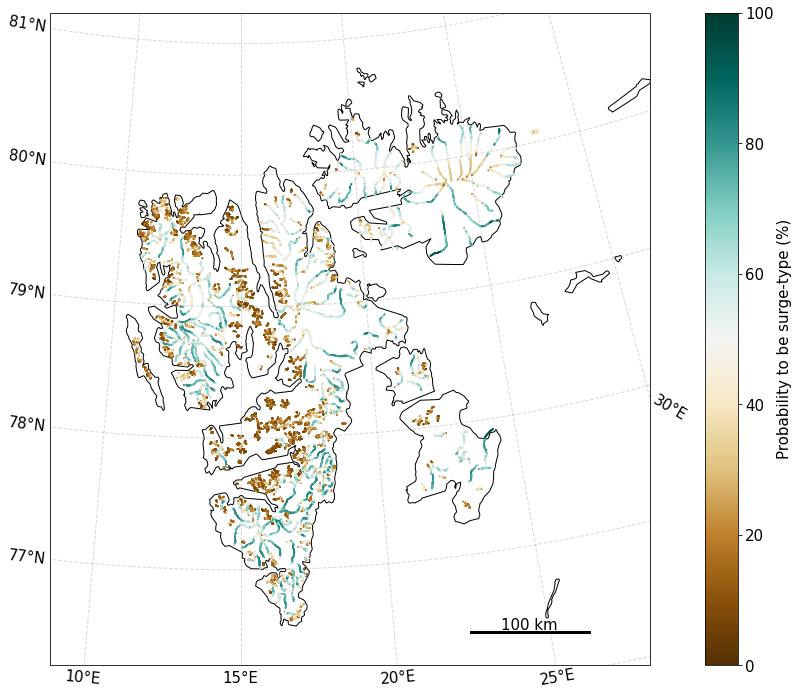

In [27]:
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='white'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=1                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.3
                , linestyle='--')
    
gl.xlabels_top = gl.ylabels_right = gl.ylabels_top = False 
gl.ylabels_bottom = True # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.xlocator = mticker.FixedLocator([10, 15, 20, 25, 30])        # sets longitude tick marks
# gl.ylocator = mticker.FixedLocator([-180, -90, 0, 90, 180])  
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

ax.set_extent([svalbard_bounding_box['left_lon']-1,
               svalbard_bounding_box['right_lon']+2,
               svalbard_bounding_box['bottom_lat'],
               svalbard_bounding_box['top_lat']+0.5
              ], crs=ccrs.PlateCarree())

cbar = ax.scatter(df_probability_surge_full.x.values
        ,df_probability_surge_full.y.values               # plots your data points on the axes
#         , marker='o'                                 # symbol for data point
        , marker='.'                                 # symbol for data point
        , s=2                                 # symbol for data point
        , c=df_probability_surge_full.Probability_1*100
        , cmap = 'BrBG'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

#fig.colorbar(cbar, label='Probability to be surge-type (%)')

cb = fig.colorbar(cbar)
#cb.set_tickparams(labelsize=15) 
cb.set_label(label='Probability to be surge-type (%)',  size=15)
cb.ax.tick_params(labelsize=15)

#plt.figure.axes.tick_params(axis="both", labelsize=15)
#plt.figure.axes[1].tick_params(axis="x", labelsize=15)

scale_bar(ax, 100)
#plt.text(0.3, 0.95,'Observed surges (2016-2021)',
#     horizontalalignment='center',
#     verticalalignment='center',
#         fontsize=15,
#     transform = ax.transAxes)

plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/map_proba_svalbard.pdf', bbox_inches='tight')

# Comparison with RGI

In [28]:
df_compare = df_main.join(df_probability_surge_full.set_index(['x', 'y'], append=True), on=['rgiid', 'x', 'y'])

## Cumulative probaility function

In [29]:
def gethistcum(data):
    '''
    This function allows to calculate cumulative sum
    '''
    h, e = np.histogram(data*100, bins=np.linspace(0, 100, 1001))
#     print(h)
    h = h/h.sum()*100
#     print(h)
    return h.cumsum(), e

In [30]:
def gethist(data):
    '''
    The function produce histogram
    '''
    h, e = np.histogram(data, bins=np.linspace(0, 1, 51))
#     print(h)
    h = h/h.sum()
#     print(h)
    return h, e

In [31]:
cmap = mpl.cm.get_cmap('BrBG')

<AxesSubplot:>

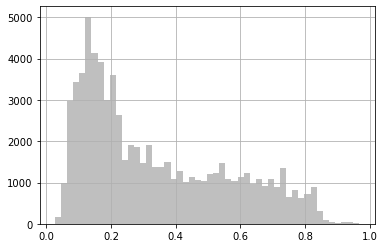

In [32]:
df_probability_surge_full.Probability_1.hist(bins=50, color='grey', alpha=0.5)

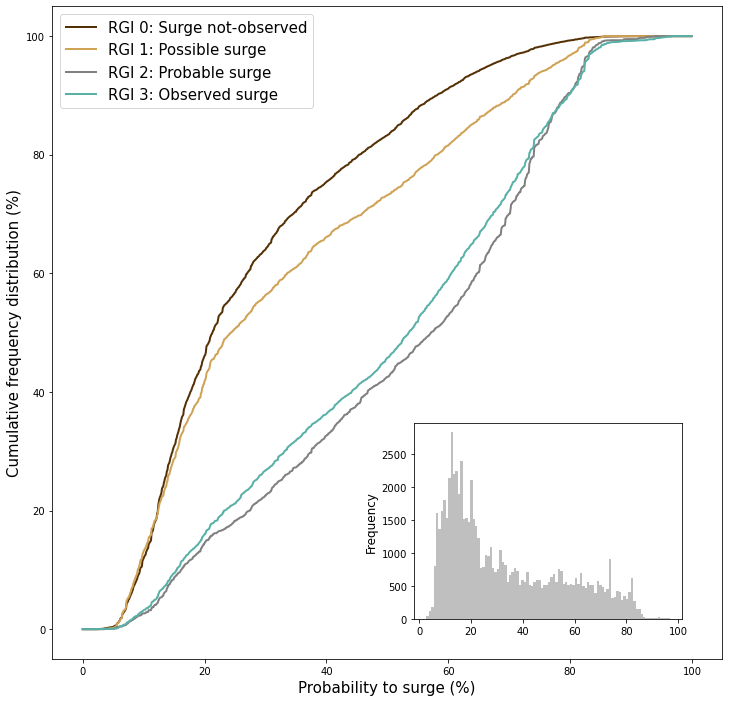

In [66]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(12, 12))

axins2 = inset_axes(ax, width="40%", height="30%", loc=4, borderpad=4)

data = df_compare[df_compare.Surge==0].copy()
h, e = gethistcum(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 0: Surge not-observed', color=cmap(0), linewidth=2)

data = df_compare[df_compare.Surge==1].copy()
h, e = gethistcum(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 1: Possible surge', color=cmap(0.25), linewidth=2)

data = df_compare[df_compare.Surge==2].copy()
h, e = gethistcum(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 2: Probable surge', color='grey', linewidth=2)

data = df_compare[df_compare.Surge==3].copy()
h, e = gethistcum(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 3: Observed surge', color=cmap(0.75), linewidth=2)

axins2.hist(df_probability_surge_full.Probability_1*100, 100, color='grey', alpha=0.5)
#axins2.set_xlabel('Probability to surge', fontsize=12)
axins2.set_ylabel('Frequency', fontsize=12)

ax.set_xlabel('Probability to surge (%)', size=15)
ax.set_ylabel('Cumulative frequency distribution (%)', size=15)

ax.legend(fontsize=15)

plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/cumulative_proba.pdf', bbox_inches='tight')

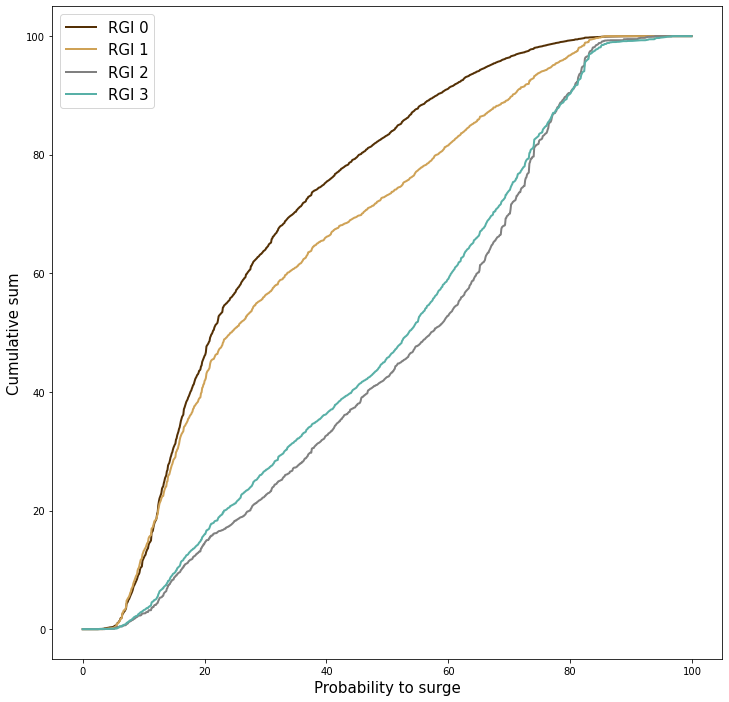

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))

data = df_compare[df_compare.Surge==0].copy()
h, e = gethistcum(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 0', color=cmap(0), linewidth=2)

data = df_compare[df_compare.Surge==1].copy()
h, e = gethistcum(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 1', color=cmap(0.25), linewidth=2)

data = df_compare[df_compare.Surge==2].copy()
h, e = gethistcum(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 2', color='grey', linewidth=2)

data = df_compare[df_compare.Surge==3].copy()
h, e = gethistcum(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 3', color=cmap(0.75), linewidth=2)

ax.set_xlabel('Probability to surge', fontsize=15)
ax.set_ylabel('Cumulative sum', fontsize=15)

ax.legend(fontsize=15)

#plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/cumulative_proba.pdf', bbox_inches='tight')

# Map for comparison with RGI

In [35]:
df = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced_clean/df_center.csv', index_col=0)
df.head()

/home/colili/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,rgiid,x,y,Surge,BgnDate,EndDate,CenLon,CenLat,Area,Zmin,...,check_geom,geometry,bed,thickness,surface_elevation,width_centerline,Runoff,ELA,beta,cmb
0,RGI60-07.00001,552858.197838,8.514877e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,86.307950,1.939792,489.989929,0.004318,-0.982753
1,RGI60-07.00001,552837.209663,8.514876e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,52.001931,1.940386,489.989929,0.004320,-0.983169
2,RGI60-07.00001,552816.221488,8.514875e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,63.412109,1.940980,489.989929,0.004321,-0.983585
3,RGI60-07.00001,552795.233313,8.514875e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,74.822291,1.941574,489.989929,0.004323,-0.984002
4,RGI60-07.00001,552774.245139,8.514874e+06,0,20080901,-9999999,17.0347,76.7052,0.597,142,...,NaN,NaN,401.83295,4.16705,406.0,112.223246,1.942168,489.989929,0.004324,-0.984418


In [36]:
df_map = df.groupby('rgiid').median()
df_map.drop(columns=['Slope', 'bed', 'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb', 'width_centerline'])
df_map.to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_map.csv')
df_map.shape

(1612, 27)

In [37]:
outlines = gpd.read_file('/home/colili/Documents/PhD/project_john/data_set/RGI60/07_rgi60_Svalbard.shp')
outlines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
outlines = outlines.to_crs("EPSG:32633")
outlines.shape

(1615, 23)

In [39]:
cmap = mpl.cm.get_cmap('BrBG')
colors = {0:cmap(0), 1:cmap(0.25), 2:cmap(0.5), 3:cmap(0.75), 9:cmap(1)}
outlines['color'] = outlines.Surging.apply(lambda x: colors[x])

/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


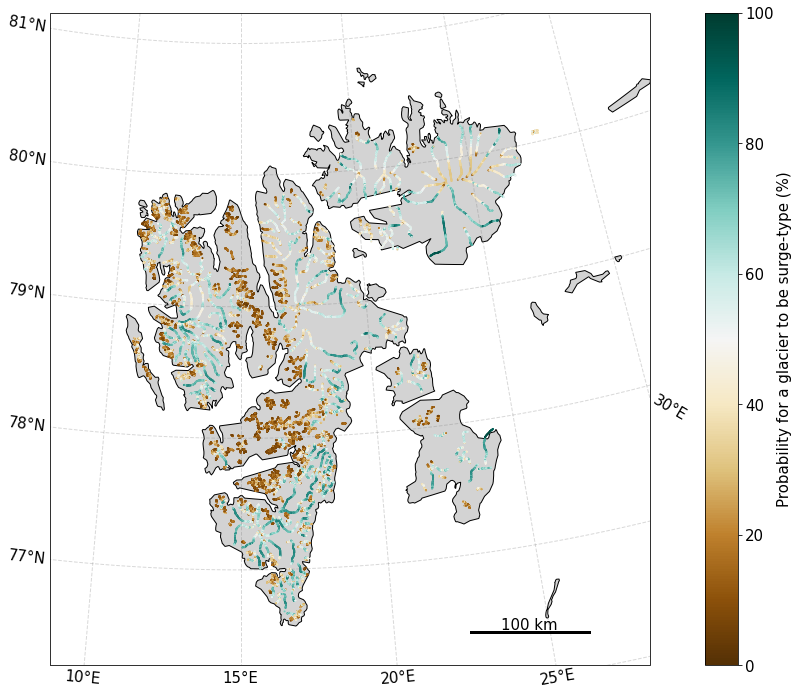

In [88]:
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

#ax.add_geometries(outlines.geometry.values, facecolor=outlines.color.values, crs=proj, alpha=0.3)

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=1                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.3
                , linestyle='--')
    
gl.xlabels_top = gl.ylabels_right = gl.ylabels_top = False 
gl.ylabels_bottom = True # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.xlocator = mticker.FixedLocator([10, 15, 20, 25, 30])        # sets longitude tick marks
# gl.ylocator = mticker.FixedLocator([-180, -90, 0, 90, 180])  
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

ax.set_extent([svalbard_bounding_box['left_lon']-1,
               svalbard_bounding_box['right_lon']+2,
               svalbard_bounding_box['bottom_lat'],
               svalbard_bounding_box['top_lat']+0.5
              ], crs=ccrs.PlateCarree())

cbar = ax.scatter(df_probability_surge_full.x.values
        ,df_probability_surge_full.y.values               # plots your data points on the axes
#         , marker='o'                                 # symbol for data point
        , marker='.'                                 # symbol for data point
        , s=3                                 # symbol for data point
        , c=df_probability_surge_full.Probability_1*100
        , cmap = 'BrBG'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

#cbar.set_label(label='Probability to be surge-type (%)', size='large')
cb = fig.colorbar(cbar)
cb.ax.tick_params(labelsize=15)
cb.ax.set_ylabel('Probability for a glacier to be surge-type (%)', fontsize=15)
scale_bar(ax, 100)

plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/map_proba_svalbard.pdf', bbox_inches='tight')

In [90]:
df_probability_surge_full.shape

(72006, 5)

In [91]:
df_probability_surge_full[df_probability_surge_full.Probability_1 > 0.5].count()

x                18790
y                18790
Probability_0    18790
Probability_1    18790
Predictions      18790
dtype: int64

In [92]:
72006/18790

3.83214475784992

In [94]:
df_group_glacier = df_probability_surge_full.groupby('rgiid').mean()
df_group_glacier

,x,y,Probability_0,Probability_1,Predictions
rgiid,,,,,
RGI60-07.00006,535879.995927,8.540103e+06,0.671536,0.328464,0.028302
RGI60-07.00008,527521.431976,8.551301e+06,0.859185,0.140815,0.000000
RGI60-07.00010,519433.987296,8.551664e+06,0.894878,0.105122,0.000000
RGI60-07.00024,526972.657902,8.586107e+06,0.893838,0.106162,0.000000
RGI60-07.00025,671180.727654,8.829493e+06,0.211234,0.788766,0.932432
...,...,...,...,...,...
RGI60-07.01560,620526.853510,8.756414e+06,0.394348,0.605652,0.785714
RGI60-07.01561,595074.045215,8.786848e+06,0.541982,0.458018,0.384615
RGI60-07.01564,568958.891349,8.776560e+06,0.458865,0.541135,0.578947


In [96]:
prob_1 = df_group_glacier['Probability_1']
prob_1[prob_1 > 0.5].count()

162

# Map comparison with RGI database (us:2 classes and RGI 0 and 1 --> no-surge; RGI 2-3 --> surge)

In [41]:
df_compare.shape

(72006, 20)

In [42]:
df_compare.groupby('Surge').describe()

Area                                                          \
         count        mean         std    min     25%     50%      75%   
Surge                                                                    
0      47106.0   43.170525  111.944786  1.001   2.528   6.845   26.722   
1      10040.0   40.565878   68.500444  1.155   2.718  10.367   51.168   
2       4195.0  153.887320  300.599819  1.102  15.126  60.123  119.079   
3      10665.0  132.770892  232.892050  1.113  15.812  48.079  113.645   

                     bed              ... Probability_1           Predictions  \
            max    count        mean  ...           75%       max       count   
Surge                                 ...                                       
0       876.603  47106.0  328.372853  ...      0.396760  0.931941     47106.0   
1       326.504  10040.0  339.763982  ...      0.526113  0.856388     10040.0   
2      1226.367   4195.0  219.653059  ...      0.726860  0.939053      4195.0   
3      1095.853  10665.0  227.450266  ...      0.705145  0.967794     10665.0   

                                                    
           mean       std  min  25%  50%  75%  max  
Surge                                               
0      0.167516  0.373440  0.0  0.0  0.0  0.0  1.0  
1      0.268526  0.443215  0.0  0.0  0.0  1.0  1.0  
2      0.574970  0.494406  0.0  0.0  1.0  1.0  1.0  
3      0.542991  0.498172  0.0  0.0  1.0  1.0  1.0  

[4 rows x 144 columns]

In [43]:
df_compare.reset_index(level=['x', 'y'], inplace=True)

In [44]:
df_compare_mean = df_compare.groupby('rgiid').mean()
df_compare_mean

,x,y,Surge,Area,bed,thickness,surface_elevation,width_centerline,Runoff,ELA,...,cmb,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00006,535879.995927,8.540103e+06,0.0,13.618,242.851795,56.751978,299.603774,1157.636719,2.207031,491.953190,...,-0.910430,5.913388,5.856958,364.319814,0.051551,0.482078,-1.322691,0.671536,0.328464,0.028302
RGI60-07.00008,527521.431976,8.551301e+06,0.0,1.577,166.470421,19.883426,186.353846,592.735950,2.671580,425.626190,...,-1.323106,15.904903,17.251566,2679.051594,0.034253,0.497777,-1.578320,0.859185,0.140815,0.000000
RGI60-07.00010,519433.987296,8.551664e+06,0.0,1.456,306.272645,19.278639,325.551282,621.081088,2.347558,428.533844,...,-0.677284,29.043179,29.307981,2630.316072,0.034346,0.474955,-0.681033,0.894878,0.105122,0.000000
RGI60-07.00024,526972.657902,8.586107e+06,0.0,1.025,394.882981,13.094032,407.977011,324.271550,1.938836,524.809380,...,-0.334028,19.887846,19.536062,55.564153,0.064260,0.483644,-0.827635,0.893838,0.106162,0.000000
RGI60-07.00025,671180.727654,8.829493e+06,3.0,1095.853,56.048288,277.689041,333.737329,21948.485828,1.354080,398.552577,...,-0.383257,0.551391,0.833276,612419.158184,0.016039,0.506320,-0.217337,0.211234,0.788766,0.932432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01560,620526.853510,8.756414e+06,3.0,594.902,96.379998,145.069699,241.449697,7058.115808,1.738133,398.493742,...,-0.848095,1.647447,1.926801,-79423.667397,0.025363,0.499000,-0.610603,0.394348,0.605652,0.785714
RGI60-07.01561,595074.045215,8.786848e+06,0.0,76.893,100.405695,123.624256,224.029952,3140.575691,1.578207,544.373427,...,-0.613566,1.232358,1.293164,-19203.999187,0.055179,0.517212,-1.004230,0.541982,0.458018,0.384615
RGI60-07.01564,568958.891349,8.776560e+06,3.0,330.996,527.980466,129.960303,657.940773,4085.535935,1.232049,614.767981,...,0.044941,2.493547,2.440198,46816.090895,0.046160,0.502852,-0.287476,0.458865,0.541135,0.578947


In [45]:
df_compare_mean['Mean_prediction'] = np.where(df_compare_mean['Probability_1']>0.5, 1, 0)
df_compare_mean

,x,y,Surge,Area,bed,thickness,surface_elevation,width_centerline,Runoff,ELA,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00006,535879.995927,8.540103e+06,0.0,13.618,242.851795,56.751978,299.603774,1157.636719,2.207031,491.953190,...,5.913388,5.856958,364.319814,0.051551,0.482078,-1.322691,0.671536,0.328464,0.028302,0
RGI60-07.00008,527521.431976,8.551301e+06,0.0,1.577,166.470421,19.883426,186.353846,592.735950,2.671580,425.626190,...,15.904903,17.251566,2679.051594,0.034253,0.497777,-1.578320,0.859185,0.140815,0.000000,0
RGI60-07.00010,519433.987296,8.551664e+06,0.0,1.456,306.272645,19.278639,325.551282,621.081088,2.347558,428.533844,...,29.043179,29.307981,2630.316072,0.034346,0.474955,-0.681033,0.894878,0.105122,0.000000,0
RGI60-07.00024,526972.657902,8.586107e+06,0.0,1.025,394.882981,13.094032,407.977011,324.271550,1.938836,524.809380,...,19.887846,19.536062,55.564153,0.064260,0.483644,-0.827635,0.893838,0.106162,0.000000,0
RGI60-07.00025,671180.727654,8.829493e+06,3.0,1095.853,56.048288,277.689041,333.737329,21948.485828,1.354080,398.552577,...,0.551391,0.833276,612419.158184,0.016039,0.506320,-0.217337,0.211234,0.788766,0.932432,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01560,620526.853510,8.756414e+06,3.0,594.902,96.379998,145.069699,241.449697,7058.115808,1.738133,398.493742,...,1.647447,1.926801,-79423.667397,0.025363,0.499000,-0.610603,0.394348,0.605652,0.785714,1
RGI60-07.01561,595074.045215,8.786848e+06,0.0,76.893,100.405695,123.624256,224.029952,3140.575691,1.578207,544.373427,...,1.232358,1.293164,-19203.999187,0.055179,0.517212,-1.004230,0.541982,0.458018,0.384615,0
RGI60-07.01564,568958.891349,8.776560e+06,3.0,330.996,527.980466,129.960303,657.940773,4085.535935,1.232049,614.767981,...,2.493547,2.440198,46816.090895,0.046160,0.502852,-0.287476,0.458865,0.541135,0.578947,1


In [46]:
df_comp = df_compare.join(df_compare_mean['Mean_prediction'])
df_comp

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00006,537340.603079,8.536963e+06,0,13.618,Chomjakovbreen,565.43870,23.561293,589.00000,1144.919151,1.520206,...,16.548017,17.115082,-20088.290815,0.020579,0.506675,0.573153,0.875269,0.124731,0,0
RGI60-07.00006,537277.114391,8.537023e+06,0,13.618,Chomjakovbreen,547.37540,24.624578,572.00000,1105.995748,1.453610,...,11.640512,10.972421,-21764.237917,0.022265,0.523348,0.459876,0.829010,0.170990,0,0
RGI60-07.00006,537213.625703,8.537084e+06,0,13.618,Chomjakovbreen,514.92160,27.078419,542.00000,1069.477866,1.434204,...,20.310906,18.888005,28786.494698,0.025319,0.970243,0.259794,0.830061,0.169939,0,0
RGI60-07.00006,537150.137016,8.537144e+06,0,13.618,Chomjakovbreen,468.15363,33.846375,502.00000,1244.957956,1.451109,...,28.074446,24.522008,8366.744828,0.027187,0.485862,-0.007378,0.829877,0.170123,0,0
RGI60-07.00006,537088.154264,8.537143e+06,0,13.618,Chomjakovbreen,468.15363,33.846375,502.00000,1162.234761,1.468375,...,28.074446,24.522008,7810.803277,0.029122,0.343524,-0.007381,0.829877,0.170123,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,534269.488654,8.675206e+06,3,5.350,Moeysalbreen,237.64468,50.380424,288.02512,278.553621,2.123592,...,-13.251281,-10.615210,-8877.735508,0.180864,0.732077,-1.566323,0.757074,0.242925,0,0
RGI60-07.01567,534310.362510,8.675249e+06,3,5.350,Moeysalbreen,233.07228,46.717087,279.78937,256.755923,2.127417,...,4.401905,7.893963,-11421.363223,0.181951,0.236503,-1.604864,0.790310,0.209690,0,0
RGI60-07.01567,534309.250485,8.675291e+06,3,5.350,Moeysalbreen,233.07228,46.717087,279.78937,238.477978,2.076787,...,4.401905,7.893963,-10608.299012,0.195897,0.093612,-1.606379,0.790310,0.209690,0,0


In [47]:
df_true = df_comp[(df_comp['Surge']==0) & (df_comp['Mean_prediction']==0) | (df_comp['Surge']==3.0) & (df_comp['Mean_prediction']==1)]
df_true

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00006,537340.603079,8.536963e+06,0,13.618,Chomjakovbreen,565.43870,23.561293,589.00000,1144.919151,1.520206,...,16.548017,17.115082,-20088.290815,0.020579,0.506675,0.573153,0.875269,0.124731,0,0
RGI60-07.00006,537277.114391,8.537023e+06,0,13.618,Chomjakovbreen,547.37540,24.624578,572.00000,1105.995748,1.453610,...,11.640512,10.972421,-21764.237917,0.022265,0.523348,0.459876,0.829010,0.170990,0,0
RGI60-07.00006,537213.625703,8.537084e+06,0,13.618,Chomjakovbreen,514.92160,27.078419,542.00000,1069.477866,1.434204,...,20.310906,18.888005,28786.494698,0.025319,0.970243,0.259794,0.830061,0.169939,0,0
RGI60-07.00006,537150.137016,8.537144e+06,0,13.618,Chomjakovbreen,468.15363,33.846375,502.00000,1244.957956,1.451109,...,28.074446,24.522008,8366.744828,0.027187,0.485862,-0.007378,0.829877,0.170123,0,0
RGI60-07.00006,537088.154264,8.537143e+06,0,13.618,Chomjakovbreen,468.15363,33.846375,502.00000,1162.234761,1.468375,...,28.074446,24.522008,7810.803277,0.029122,0.343524,-0.007381,0.829877,0.170123,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01566,497473.775937,8.649259e+06,0,6.924,Marstranderbreen,232.02019,15.078909,247.09909,521.463923,0.818021,...,5.137202,9.825886,-7164.202107,0.028916,0.407919,-1.759644,0.932155,0.067845,0,0
RGI60-07.01566,497426.775942,8.649259e+06,0,6.924,Marstranderbreen,218.39961,19.980356,238.37997,498.860288,0.810451,...,16.161565,10.509646,-4367.777335,0.040052,0.941892,-1.801810,0.932155,0.067845,0,0
RGI60-07.01566,497379.750760,8.649212e+06,0,6.924,Marstranderbreen,218.39961,19.980356,238.37997,474.359352,0.803012,...,16.161565,10.509646,-4153.259088,0.042121,0.573681,-1.808128,0.932155,0.067845,0,0


In [97]:
46170/72006

0.641196566952754

In [98]:
df_new_surge = df_comp[(df_comp['Surge']==0) & (df_comp['Mean_prediction']==1)|
                     (df_comp['Surge']==1) & (df_comp['Mean_prediction']==1)]
#|
#                     (df_compare['Surge']==2) & (df_compare['Mean_prediction']==1)]
df_new_surge

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00026,689665.629037,8.836846e+06,0,153.538,Austfonna,79.590760,343.50784,423.098600,414.676202,1.177370,...,0.858716,0.582090,107831.124990,0.828376,0.240565,-0.016371,0.737628,0.262372,0,1
RGI60-07.00026,689875.864244,8.836695e+06,0,153.538,Austfonna,73.022310,344.85202,417.874330,551.210412,1.179804,...,1.453233,1.155932,188773.928254,0.625627,0.389703,-0.021029,0.737628,0.262372,0,1
RGI60-07.00026,689905.420266,8.836514e+06,0,153.538,Austfonna,71.944490,345.24246,417.186950,559.160260,1.181205,...,0.337304,0.215117,63887.398408,0.617430,0.597605,-0.022303,0.737628,0.262372,0,1
RGI60-07.00026,689934.976139,8.836333e+06,0,153.538,Austfonna,70.124570,346.00455,416.129120,713.327378,1.182606,...,0.569532,0.331048,133091.756049,0.485057,0.738496,-0.024064,0.737628,0.262372,0,1
RGI60-07.00026,689964.531862,8.836153e+06,0,153.538,Austfonna,68.374695,346.59020,414.964900,901.954019,1.185375,...,0.547613,0.364342,162759.851320,0.384266,0.087744,-0.025180,0.713923,0.286077,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01559,584971.734816,8.784363e+06,0,876.603,Hinlopenbreen,-102.835976,168.78168,65.945700,5704.625727,2.251190,...,-1.299067,1.382892,-927508.003954,0.029587,0.838215,-1.722250,0.217467,0.782533,1,1
RGI60-07.01559,585159.947629,8.784574e+06,0,876.603,Hinlopenbreen,-100.461560,159.74393,59.282364,5728.031716,2.254021,...,-0.480936,1.349434,-423295.574256,0.027888,0.293054,-1.767391,0.217467,0.782533,1,1
RGI60-07.01559,585348.160425,8.784785e+06,0,876.603,Hinlopenbreen,-91.269720,147.57443,56.304710,5663.946120,2.256852,...,-1.861186,0.603113,-800858.332386,0.026055,0.854206,-1.788683,0.215797,0.784203,1,1


In [99]:
10123/72006

0.1405855067633253

In [49]:
df_no_surge = df_comp[(df_comp['Surge']==3) & (df_comp['Mean_prediction']==0)|
                      (df_comp['Surge']==2) & (df_comp['Mean_prediction']==0)]
    #|
#                      (df_compare['Surge']==1) & (df_compare['Mean_prediction']==0)]

In [100]:
df_no_surge.groupby('rgiid').mean()
df_no_surge

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00063,650444.196059,8.671185e+06,3,17.288,Kvitisen E,434.41806,113.581930,548.00000,553.645258,1.169460,...,-1.882570,2.975486,-59852.521561,0.205153,0.186107,-0.021973,0.755880,0.244120,0,0
RGI60-07.00063,650369.089210,8.671245e+06,3,17.288,Kvitisen E,430.40613,113.593890,544.00000,687.155808,1.164409,...,2.388253,2.381159,53396.908968,0.165310,0.306074,-0.037886,0.701141,0.298859,0,0
RGI60-07.00063,650293.982369,8.671305e+06,3,17.288,Kvitisen E,430.40613,113.593890,544.00000,962.161972,1.161297,...,2.388253,2.381159,74766.849952,0.118061,0.342161,-0.037925,0.675589,0.324411,0,0
RGI60-07.00063,650218.875535,8.671365e+06,3,17.288,Kvitisen E,431.32550,107.674510,539.00000,1363.270261,1.174685,...,-0.547591,2.975488,-76423.234024,0.078983,0.540489,-0.057796,0.682757,0.317243,0,0
RGI60-07.00063,650143.768709,8.671425e+06,3,17.288,Kvitisen E,435.57660,98.423386,534.00000,1890.154456,1.188072,...,-2.530450,2.975489,-106747.748918,0.052072,0.868487,-0.077665,0.575075,0.424925,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,534269.488654,8.675206e+06,3,5.350,Moeysalbreen,237.64468,50.380424,288.02512,278.553621,2.123592,...,-13.251281,-10.615210,-8877.735508,0.180864,0.732077,-1.566323,0.757074,0.242925,0,0
RGI60-07.01567,534310.362510,8.675249e+06,3,5.350,Moeysalbreen,233.07228,46.717087,279.78937,256.755923,2.127417,...,4.401905,7.893963,-11421.363223,0.181951,0.236503,-1.604864,0.790310,0.209690,0,0
RGI60-07.01567,534309.250485,8.675291e+06,3,5.350,Moeysalbreen,233.07228,46.717087,279.78937,238.477978,2.076787,...,4.401905,7.893963,-10608.299012,0.195897,0.093612,-1.606379,0.790310,0.209690,0,0


In [101]:
5891/72006

0.08181262672555065

/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


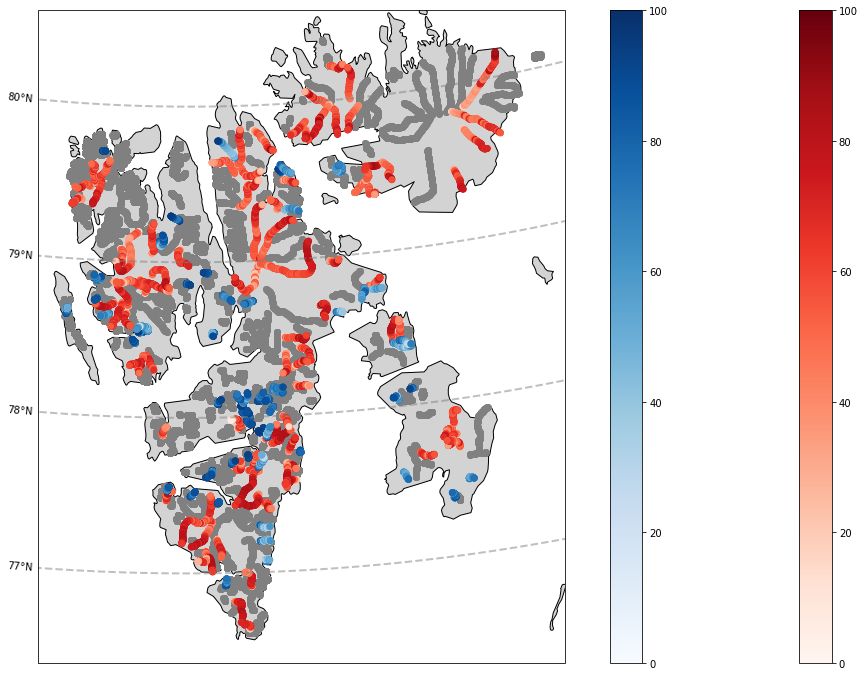

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = False                          # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.ylabels_bottom = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])        # sets longitude tick marks
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


ax.scatter(df_true.x.values
        ,df_true.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
#         , c=df_compare.Probability_1,
        ,c='grey'
#         , cmap = 'Reds'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

cbar1 = ax.scatter(df_new_surge.x.values
        ,df_new_surge.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=df_new_surge.Probability_1*100
#         ,c='grey'
        , cmap = 'Reds'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

cbar2 = ax.scatter(df_no_surge.x.values
        ,df_no_surge.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=df_no_surge.Probability_0*100
#         ,c='grey'
        , cmap = 'Blues'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in
    
fig.colorbar(cbar1)
fig.colorbar(cbar2)

In [52]:
def scale_bar(ax, length=None, location=(0.8, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
#     tmc = ccrs.TransverseMercator(sbllx, sblly)
    tmc = ccrs.UTM(33, southern_hemisphere=False, globe=None)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom', fontsize=15)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


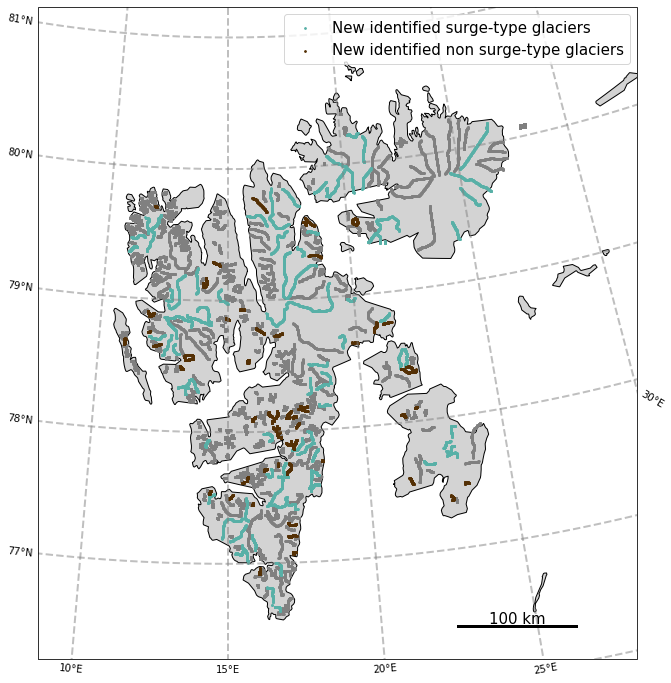

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details

ax.set_extent([svalbard_bounding_box['left_lon']-1,
               svalbard_bounding_box['right_lon']+2,
               svalbard_bounding_box['bottom_lat'],
               svalbard_bounding_box['top_lat']+0.5
              ], crs=ccrs.PlateCarree())    

gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = gl.ylabels_top = False 
gl.ylabels_bottom = True # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.xlocator = mticker.FixedLocator([10, 15, 20, 25, 30])        # sets longitude tick marks
# gl.ylocator = mticker.FixedLocator([-180, -90, 0, 90, 180])  
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

#gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


ax.scatter(df_true.x.values
        ,df_true.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
#         , c=df_compare.Probability_1,
        ,c='grey'
#         , cmap = 'Reds'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
         , s=3# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

ax.scatter(df_new_surge.x.values
        ,df_new_surge.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=cmap(0.75)
#         ,c='grey'
#        , cmap = 'Reds'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
         , s=3# opacity
#         , transform=ccrs.PlateCarree()
         ,label='New identified surge-type glaciers'
          )              # projection to plot data in

ax.scatter(df_no_surge.x.values
        ,df_no_surge.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
#        , c=df_no_surge.Probability_0*100
         ,c=cmap(0)
#        , cmap = 'Blues'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
         , s=3# opacity
#         , transform=ccrs.PlateCarree()
         ,label='New identified non surge-type glaciers'
          )              # projection to plot data in


scale_bar(ax, 100)
plt.legend(fontsize=15)
#fig.colorbar(cbar1)
#fig.colorbar(cbar2)

In [54]:
df_new_surge.groupby('Name').mean().head()

,x,y,Surge,Area,bed,thickness,surface_elevation,width_centerline,Runoff,ELA,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
Name,,,,,,,,,,,,,,,,,,,,,
Aavatsmarkbreen,439528.410543,8.738907e+06,1.0,73.265,139.205779,190.550332,329.756109,2568.476716,2.492065,595.374658,...,2.754120,2.727168,74750.668072,0.084118,0.498783,-1.368788,0.299968,0.700032,0.945455,1.0
Albrechtbreen,689753.383058,8.660244e+06,0.0,66.480,151.713263,106.531835,258.245098,5156.602468,2.130745,521.052002,...,1.143072,2.020385,43798.190542,0.028197,0.448212,-0.970449,0.418846,0.581154,0.911765,1.0
Aldousbreen,616022.966544,8.873433e+06,0.0,179.461,115.047571,218.163203,333.210772,8215.061892,1.208964,425.894955,...,0.855347,1.478883,16092.621648,0.030246,0.585672,-0.469278,0.435786,0.564214,0.682353,1.0
Andrinebreen,569876.428186,8.656349e+06,1.0,29.416,138.867227,168.431838,307.299065,1541.869274,2.301571,568.281860,...,1.699806,2.997895,-2944.012241,0.114732,0.461547,-1.251375,0.440216,0.559784,0.813084,1.0
Arnesenbreen,573514.950487,8.639245e+06,1.0,24.440,112.946563,161.664548,274.611111,1739.680550,2.203579,540.752563,...,2.880540,2.784608,-15269.322977,0.093967,0.556626,-1.261702,0.376841,0.623159,0.785714,1.0


In [55]:
df_no_surge.groupby('Name').mean()

,x,y,Surge,Area,bed,thickness,surface_elevation,width_centerline,Runoff,ELA,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
Name,,,,,,,,,,,,,,,,,,,,,
Aasgardfonna NW,526909.538753,8.851575e+06,3.0,113.645,356.475012,199.179302,555.654314,6100.981310,1.039698,523.191429,...,1.819244,2.515797,170471.436786,0.047873,0.491042,-0.034428,0.520526,0.479474,0.644444,0.0
Anna Sofiebreen,460358.699491,8.712951e+06,2.0,3.237,341.172197,60.051863,401.224062,664.100014,1.715201,591.438782,...,15.967681,16.874419,450.635517,0.213013,0.510954,-0.945019,0.817084,0.182916,0.000000,0.0
Arebreen,537739.098316,8.667430e+06,3.0,1.545,482.079325,34.684175,516.763497,518.307000,1.461418,655.193370,...,26.064038,26.237467,4135.746850,0.072200,0.504662,-0.593377,0.852862,0.147138,0.000000,0.0
Austre Broeggerbreen,432713.762374,8.759270e+06,3.0,9.811,192.704941,76.114701,268.819642,892.353816,2.537436,556.343506,...,8.660090,8.120382,2668.424859,0.089998,0.485770,-1.428478,0.705006,0.294994,0.000000,0.0
Backlundbreen,607744.733321,8.734519e+06,3.0,20.078,96.363642,95.655811,192.019452,3635.788196,1.567867,421.030548,...,4.628215,5.164706,31223.115589,0.050016,0.527026,-0.738492,0.564627,0.435373,0.304348,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Svelgfjellet,490046.704780,8.801276e+06,3.0,11.886,563.534765,64.552142,628.086907,854.205753,1.063641,753.526969,...,9.762848,9.646485,-9983.775091,0.078476,0.526499,-0.401358,0.804045,0.195955,0.000000,0.0
Tindebreen,438973.727992,8.849868e+06,3.0,1.113,350.295085,19.997049,370.292135,428.925101,1.997772,513.722748,...,46.903280,46.698679,1049.983186,0.048911,0.514310,-0.688085,0.875279,0.124721,0.000000,0.0
Vegardbreen,465449.021584,8.719794e+06,2.0,10.140,276.233559,75.676349,351.909908,687.340978,1.686923,590.949222,...,7.574185,7.678595,-5203.155082,0.121187,0.475962,-1.407425,0.791323,0.208677,0.000000,0.0


# Comparison 4 classes (0-25 --> RGI 0, 25-50 --> RGI 1, 50-75 --> RGI 2, 75-100 --> RGI 3)

In [56]:
df_compare_mean.shape

(738, 22)

In [57]:
df_compare_mean.loc[df_compare_mean.Probability_1 < 0.25, "Mean_prediction"] = 0
df_compare_mean.loc[(df_compare_mean.Probability_1 > 0.25) & (df_compare_mean.Probability_1 < 0.5), "Mean_prediction"] =1
df_compare_mean.loc[(df_compare_mean.Probability_1 > 0.5) & (df_compare_mean.Probability_1 < 0.75), "Mean_prediction"] =2
df_compare_mean.loc[df_compare_mean.Probability_1 > 0.75, "Mean_prediction"] =3
df_compare_mean.groupby('Mean_prediction').count()

,x,y,Surge,Area,bed,thickness,surface_elevation,width_centerline,Runoff,ELA,...,cmb,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions
Mean_prediction,,,,,,,,,,,,,,,,,,,,,
0,395,395,395,395,395,395,395,395,395,395,...,395,395,395,395,395,395,395,395,395,395
1,181,181,181,181,181,181,181,181,181,181,...,181,181,181,181,181,181,181,181,181,181
2,159,159,159,159,159,159,159,159,159,159,...,159,159,159,159,159,159,159,159,159,159
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [58]:
df_class = df_compare.join(df_compare_mean['Mean_prediction'])
df_class

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00006,537340.603079,8.536963e+06,0,13.618,Chomjakovbreen,565.43870,23.561293,589.00000,1144.919151,1.520206,...,16.548017,17.115082,-20088.290815,0.020579,0.506675,0.573153,0.875269,0.124731,0,1
RGI60-07.00006,537277.114391,8.537023e+06,0,13.618,Chomjakovbreen,547.37540,24.624578,572.00000,1105.995748,1.453610,...,11.640512,10.972421,-21764.237917,0.022265,0.523348,0.459876,0.829010,0.170990,0,1
RGI60-07.00006,537213.625703,8.537084e+06,0,13.618,Chomjakovbreen,514.92160,27.078419,542.00000,1069.477866,1.434204,...,20.310906,18.888005,28786.494698,0.025319,0.970243,0.259794,0.830061,0.169939,0,1
RGI60-07.00006,537150.137016,8.537144e+06,0,13.618,Chomjakovbreen,468.15363,33.846375,502.00000,1244.957956,1.451109,...,28.074446,24.522008,8366.744828,0.027187,0.485862,-0.007378,0.829877,0.170123,0,1
RGI60-07.00006,537088.154264,8.537143e+06,0,13.618,Chomjakovbreen,468.15363,33.846375,502.00000,1162.234761,1.468375,...,28.074446,24.522008,7810.803277,0.029122,0.343524,-0.007381,0.829877,0.170123,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,534269.488654,8.675206e+06,3,5.350,Moeysalbreen,237.64468,50.380424,288.02512,278.553621,2.123592,...,-13.251281,-10.615210,-8877.735508,0.180864,0.732077,-1.566323,0.757074,0.242925,0,0
RGI60-07.01567,534310.362510,8.675249e+06,3,5.350,Moeysalbreen,233.07228,46.717087,279.78937,256.755923,2.127417,...,4.401905,7.893963,-11421.363223,0.181951,0.236503,-1.604864,0.790310,0.209690,0,0
RGI60-07.01567,534309.250485,8.675291e+06,3,5.350,Moeysalbreen,233.07228,46.717087,279.78937,238.477978,2.076787,...,4.401905,7.893963,-10608.299012,0.195897,0.093612,-1.606379,0.790310,0.209690,0,0


In [59]:
df_true_class = df_class[(df_class['Surge']==0) & (df_class['Mean_prediction']==0)|(df_class['Surge']==1) & (df_class['Mean_prediction']==1)
                        |(df_class['Surge']==2) & (df_class['Mean_prediction']==2)|(df_class['Surge']==3) & (df_class['Mean_prediction']==3)]
df_true_class        

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00008,528138.747724,8.551696e+06,0,1.577,Lorchbreen,249.342510,29.657492,279.0,610.146668,1.971497,...,56.653499,52.882873,1.893488e+03,0.048607,0.996905,-0.981818,0.845799,0.154201,0,0
RGI60-07.00008,528139.273240,8.551668e+06,0,1.577,Lorchbreen,249.342510,29.657492,279.0,641.135595,1.990355,...,56.653499,52.882873,1.989657e+03,0.046258,0.779350,-0.981890,0.845799,0.154201,0,0
RGI60-07.00008,528139.798755,8.551640e+06,0,1.577,Lorchbreen,249.342510,29.657492,279.0,673.089295,2.009213,...,56.653499,52.882873,2.088820e+03,0.044062,0.824799,-0.981962,0.838811,0.161189,0,0
RGI60-07.00008,528140.324270,8.551612e+06,0,1.577,Lorchbreen,249.342510,29.657492,279.0,705.240417,2.028072,...,56.653499,52.882873,2.188595e+03,0.042053,0.404917,-0.982034,0.838811,0.161189,0,0
RGI60-07.00008,528140.849785,8.551584e+06,0,1.577,Lorchbreen,227.258070,30.741926,258.0,739.518079,2.046930,...,38.263635,36.869631,1.216309e+04,0.041570,0.790695,-1.122764,0.822043,0.177957,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01554,713335.569761,8.665691e+06,3,581.764,Stonebreen,-26.247680,69.247680,43.0,88505.889209,2.042516,...,-3.138819,1.431303,-1.699770e+04,0.000782,0.540971,-1.120319,0.089418,0.910582,1,3
RGI60-07.01554,713503.791030,8.665918e+06,3,581.764,Stonebreen,-51.063240,87.063240,36.0,88490.060119,2.041554,...,5.011308,1.416922,-7.362590e+06,0.000984,0.050590,-1.154189,0.071997,0.928003,1,3
RGI60-07.01554,713701.689473,8.665948e+06,3,581.764,Stonebreen,-36.365845,71.365845,35.0,88570.701351,2.047663,...,-4.200610,0.286317,5.511051e+06,0.000806,0.608377,-1.168386,0.089418,0.910582,1,3


In [60]:
df_new_0 = df_class[(df_class['Surge']==1) & (df_class['Mean_prediction']==0)|(df_class['Surge']==2) & (df_class['Mean_prediction']==0)
                   |(df_class['Surge']==3) & (df_class['Mean_prediction']==0)]
df_new_0    

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00093,523466.449233,8.593293e+06,1,3.259,Aurkollfonna,547.23220,26.767836,574.00000,199.014489,1.521359,...,42.600484,35.264208,-5232.340517,0.134502,0.259311,0.606626,0.875283,0.124717,0,0
RGI60-07.00093,523467.031272,8.593258e+06,1,3.259,Aurkollfonna,547.23220,26.767836,574.00000,268.495820,1.539439,...,42.600484,35.264208,-7059.091854,0.099696,0.577133,0.607709,0.875283,0.124717,0,0
RGI60-07.00093,523432.617914,8.593223e+06,1,3.259,Aurkollfonna,547.23220,26.767836,574.00000,425.330114,1.555032,...,42.600484,35.264208,-11182.462146,0.062934,0.088592,0.607069,0.875283,0.124717,0,0
RGI60-07.00093,523433.199951,8.593188e+06,1,3.259,Aurkollfonna,518.39600,28.603992,547.00000,382.838390,1.575226,...,39.484629,37.647435,10699.234246,0.074716,0.976481,0.450532,0.875283,0.124717,0,0
RGI60-07.00093,523398.786592,8.593152e+06,1,3.259,Aurkollfonna,518.39600,28.603992,547.00000,510.735496,1.590819,...,39.484629,37.647435,14273.591281,0.056005,0.192381,0.450058,0.875283,0.124717,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,534269.488654,8.675206e+06,3,5.350,Moeysalbreen,237.64468,50.380424,288.02512,278.553621,2.123592,...,-13.251281,-10.615210,-8877.735508,0.180864,0.732077,-1.566323,0.757074,0.242925,0,0
RGI60-07.01567,534310.362510,8.675249e+06,3,5.350,Moeysalbreen,233.07228,46.717087,279.78937,256.755923,2.127417,...,4.401905,7.893963,-11421.363223,0.181951,0.236503,-1.604864,0.790310,0.209690,0,0
RGI60-07.01567,534309.250485,8.675291e+06,3,5.350,Moeysalbreen,233.07228,46.717087,279.78937,238.477978,2.076787,...,4.401905,7.893963,-10608.299012,0.195897,0.093612,-1.606379,0.790310,0.209690,0,0


In [61]:
df_new_1 = df_class[(df_class['Surge']==0) & (df_class['Mean_prediction']==1)|(df_class['Surge']==2) & (df_class['Mean_prediction']==1)
                   |(df_class['Surge']==3) & (df_class['Mean_prediction']==1)]
df_new_1 

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00006,537340.603079,8.536963e+06,0,13.618,Chomjakovbreen,565.43870,23.561293,589.00000,1144.919151,1.520206,...,16.548017,17.115082,-20088.290815,0.020579,0.506675,0.573153,0.875269,0.124731,0,1
RGI60-07.00006,537277.114391,8.537023e+06,0,13.618,Chomjakovbreen,547.37540,24.624578,572.00000,1105.995748,1.453610,...,11.640512,10.972421,-21764.237917,0.022265,0.523348,0.459876,0.829010,0.170990,0,1
RGI60-07.00006,537213.625703,8.537084e+06,0,13.618,Chomjakovbreen,514.92160,27.078419,542.00000,1069.477866,1.434204,...,20.310906,18.888005,28786.494698,0.025319,0.970243,0.259794,0.830061,0.169939,0,1
RGI60-07.00006,537150.137016,8.537144e+06,0,13.618,Chomjakovbreen,468.15363,33.846375,502.00000,1244.957956,1.451109,...,28.074446,24.522008,8366.744828,0.027187,0.485862,-0.007378,0.829877,0.170123,0,1
RGI60-07.00006,537088.154264,8.537143e+06,0,13.618,Chomjakovbreen,468.15363,33.846375,502.00000,1162.234761,1.468375,...,28.074446,24.522008,7810.803277,0.029122,0.343524,-0.007381,0.829877,0.170123,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01566,497473.775937,8.649259e+06,0,6.924,Marstranderbreen,232.02019,15.078909,247.09909,521.463923,0.818021,...,5.137202,9.825886,-7164.202107,0.028916,0.407919,-1.759644,0.932155,0.067845,0,1
RGI60-07.01566,497426.775942,8.649259e+06,0,6.924,Marstranderbreen,218.39961,19.980356,238.37997,498.860288,0.810451,...,16.161565,10.509646,-4367.777335,0.040052,0.941892,-1.801810,0.932155,0.067845,0,1
RGI60-07.01566,497379.750760,8.649212e+06,0,6.924,Marstranderbreen,218.39961,19.980356,238.37997,474.359352,0.803012,...,16.161565,10.509646,-4153.259088,0.042121,0.573681,-1.808128,0.932155,0.067845,0,1


In [62]:
df_new_2 = df_class[(df_class['Surge']==0) & (df_class['Mean_prediction']==2)|(df_class['Surge']==1) & (df_class['Mean_prediction']==2)
                   |(df_class['Surge']==3) & (df_class['Mean_prediction']==2)]
df_new_2 

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00026,689665.629037,8.836846e+06,0,153.538,Austfonna,79.590760,343.50784,423.098600,414.676202,1.177370,...,0.858716,0.582090,107831.124990,0.828376,0.240565,-0.016371,0.737628,0.262372,0,2
RGI60-07.00026,689875.864244,8.836695e+06,0,153.538,Austfonna,73.022310,344.85202,417.874330,551.210412,1.179804,...,1.453233,1.155932,188773.928254,0.625627,0.389703,-0.021029,0.737628,0.262372,0,2
RGI60-07.00026,689905.420266,8.836514e+06,0,153.538,Austfonna,71.944490,345.24246,417.186950,559.160260,1.181205,...,0.337304,0.215117,63887.398408,0.617430,0.597605,-0.022303,0.737628,0.262372,0,2
RGI60-07.00026,689934.976139,8.836333e+06,0,153.538,Austfonna,70.124570,346.00455,416.129120,713.327378,1.182606,...,0.569532,0.331048,133091.756049,0.485057,0.738496,-0.024064,0.737628,0.262372,0,2
RGI60-07.00026,689964.531862,8.836153e+06,0,153.538,Austfonna,68.374695,346.59020,414.964900,901.954019,1.185375,...,0.547613,0.364342,162759.851320,0.384266,0.087744,-0.025180,0.713923,0.286077,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01564,580726.818335,8.786065e+06,3,330.996,Oslobreen,-27.886635,109.12240,81.235760,2281.440229,2.311483,...,-1.581247,0.322279,-248942.637724,0.047830,0.112421,-1.633650,0.237086,0.762914,1,2
RGI60-07.01564,580715.727295,8.786264e+06,3,330.996,Oslobreen,-23.670998,105.92551,82.254510,2277.489871,2.312263,...,-1.207418,-0.291825,-225491.396001,0.046510,0.985742,-1.640631,0.237086,0.762914,1,2
RGI60-07.01564,580704.636189,8.786464e+06,3,330.996,Oslobreen,-20.922882,103.11172,82.188835,2257.937873,2.309162,...,-0.787167,0.018813,-164919.369352,0.045666,0.330091,-1.642427,0.237086,0.762914,1,2


In [63]:
df_new_3 = df_class[(df_class['Surge']==0) & (df_class['Mean_prediction']==3)|(df_class['Surge']==1) & (df_class['Mean_prediction']==3)
                   |(df_class['Surge']==2) & (df_class['Mean_prediction']==3)]
df_new_3 

,x,y,Surge,Area,Name,bed,thickness,surface_elevation,width_centerline,Runoff,...,Bed_slope,Surface_slope,WHsin,WH,dummy,SMB_calc,Probability_0,Probability_1,Predictions,Mean_prediction
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.01546,701454.058942,8.636039e+06,2,186.971,Deltabreen,237.750670,217.249330,455.0,10495.573750,1.863047,...,-13.107950,0.809829,-1.175397e+06,0.020699,0.533075,-0.275698,0.363972,0.636028,1,3
RGI60-07.01546,701256.044177,8.636010e+06,2,186.971,Deltabreen,231.279560,218.720440,450.0,10346.032902,1.865029,...,1.852272,1.431387,2.173836e+06,0.021141,0.594066,-0.308293,0.373964,0.626036,1,3
RGI60-07.01546,701058.029600,8.635982e+06,2,186.971,Deltabreen,269.460020,172.539980,442.0,10196.492069,1.872156,...,-10.802637,2.289479,1.726659e+06,0.016922,0.296123,-0.356051,0.390854,0.609146,1,3
RGI60-07.01546,700860.015213,8.635953e+06,2,186.971,Deltabreen,295.054720,157.945280,453.0,10046.951252,1.881180,...,-7.289142,-3.146546,-1.340387e+06,0.015721,0.181052,-0.317738,0.449531,0.550469,1,3
RGI60-07.01546,700662.001014,8.635924e+06,2,186.971,Deltabreen,314.912300,143.087700,458.0,9897.410451,1.890204,...,-5.667419,-1.431391,8.179732e+05,0.014457,0.129022,-0.302656,0.498997,0.501003,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01546,694357.864962,8.622269e+06,2,186.971,Deltabreen,-47.918327,110.918330,63.0,5943.576227,2.383010,...,2.050517,2.428278,5.848378e+05,0.018662,0.662912,-1.430096,0.280080,0.719920,1,3
RGI60-07.01546,694159.855224,8.622240e+06,2,186.971,Deltabreen,-54.735750,112.735750,58.0,6158.788558,2.390898,...,1.951394,1.431437,6.446323e+05,0.018305,0.462012,-1.452824,0.265887,0.734113,1,3
RGI60-07.01546,693990.637627,8.622013e+06,2,186.971,Deltabreen,-66.983800,116.983800,50.0,6093.505153,2.402858,...,2.478415,1.619394,4.388422e+05,0.019198,0.796137,-1.490493,0.265887,0.734113,1,3


/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* &

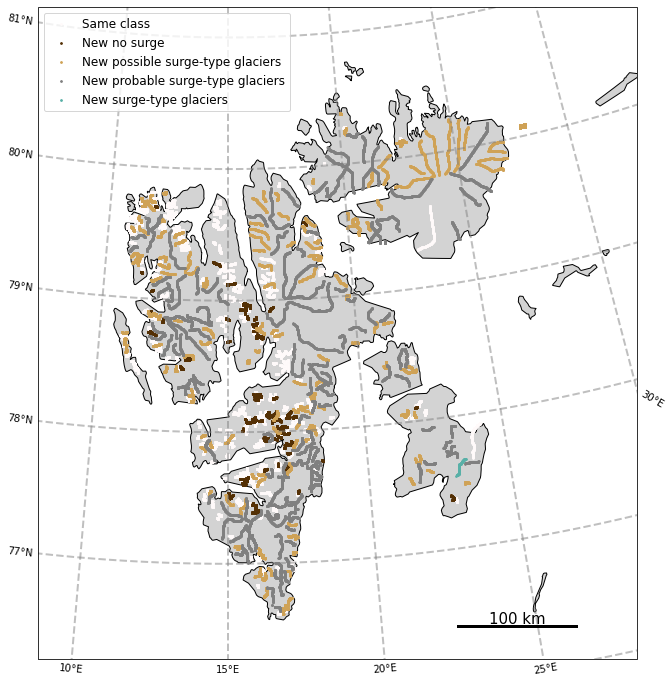

In [64]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details

ax.set_extent([svalbard_bounding_box['left_lon']-1,
               svalbard_bounding_box['right_lon']+2,
               svalbard_bounding_box['bottom_lat'],
               svalbard_bounding_box['top_lat']+0.5
              ], crs=ccrs.PlateCarree())    

gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = gl.ylabels_top = False 
gl.ylabels_bottom = True # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.xlocator = mticker.FixedLocator([10, 15, 20, 25, 30])        # sets longitude tick marks
# gl.ylocator = mticker.FixedLocator([-180, -90, 0, 90, 180])  
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

#gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


ax.scatter(df_true.x.values
        ,df_true.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
#         , c=df_compare.Probability_1,
        ,c='snow'
#         , cmap = 'Reds'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
         , s=3# opacity
#         , transform=ccrs.PlateCarree()
         ,label='Same class'
          )              # projection to plot data in

ax.scatter(df_new_0.x.values
        ,df_new_0.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=cmap(0)
#         ,c='grey'
#        , cmap = 'Reds'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
         , s=3# opacity
#         , transform=ccrs.PlateCarree()
         ,label='New no surge'
          )              # projection to plot data in

ax.scatter(df_new_1.x.values
        ,df_new_1.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
#        , c=df_no_surge.Probability_0*100
         ,c=cmap(0.25)
#        , cmap = 'Blues'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
         , s=3# opacity
#         , transform=ccrs.PlateCarree()
         ,label='New possible surge-type glaciers'
          )              # projection to plot data in

ax.scatter(df_new_2.x.values
        ,df_new_2.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
#        , c=df_no_surge.Probability_0*100
         ,c='grey'
#        , cmap = 'Blues'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
         , s=3# opacity
#         , transform=ccrs.PlateCarree()
         ,label='New probable surge-type glaciers'
          )              # projection to plot data in

ax.scatter(df_new_3.x.values
        ,df_new_3.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
#        , c=df_no_surge.Probability_0*100
         ,c=cmap(0.75)
#        , cmap = 'Blues'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
         , s=3# opacity
#         , transform=ccrs.PlateCarree()
         ,label='New surge-type glaciers'
          )              # projection to plot data in

scale_bar(ax, 100)
plt.legend(fontsize=12, loc ='upper left')
#fig.colorbar(cbar1)
#fig.colorbar(cbar2)